<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/pytrends_eda_notebook_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTrends EDA Template

This notebook pulls Google Trends data via **PyTrends** (or uses synthetic data if offline), performs exploratory data analysis (descriptive statistics + visualizations), and saves outputs. It is designed to satisfy the EDA rubric for your DAT 490 project.

## Setup

Install required packages (run in terminal):

```bash
pip install pytrends pandas matplotlib seaborn plotly nbformat
```

If pytrends or network access is unavailable, the notebook falls back to a synthetic dataset for demonstration.

In [24]:
# Optional: install packages from the notebook
# !pip install pytrends pandas matplotlib seaborn plotly nbformat


In [43]:
!pip install pytrends pandas matplotlib seaborn plotly nbformat

In [44]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
OUTPUT_DIR = 'pytrends_eda_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
sns.set(style='whitegrid')


In [45]:
def synthetic_trends(keywords, start='2021-01-01', end='2025-10-01', seed=42):
    rng = pd.date_range(start=start, end=end, freq='W-SUN')
    np.random.seed(seed)
    data = pd.DataFrame(index=rng)
    for kw in keywords:
        base = np.random.poisson(lam=5, size=len(rng)).astype(float)
        spikes = np.zeros(len(rng))
        for i in range(3):
            loc = np.random.randint(0, len(rng))
            width = np.random.randint(1, 6)
            height = np.random.randint(30, 90)
            start_i = max(0, loc - width)
            end_i = min(len(rng), loc + width)
            spikes[start_i:end_i] += np.linspace(height, 0, end_i-start_i)
        series = (base + spikes).clip(0, 100)
        series = (series / series.max() * 100) if series.max() > 0 else series
        data[kw] = series.round(1)
    return data

def descriptive_stats(df):
    stats = df.describe().T
    stats['skew'] = df.skew()
    stats['kurtosis'] = df.kurtosis()
    return stats

def save_fig(fig, name):
    out = os.path.join(OUTPUT_DIR, name)
    fig.savefig(out, dpi=150, bbox_inches='tight')
    print('Saved', out)


## Fetch Google Trends Data
Edit `keywords`, `timeframe`, `geo`, and `gprop` below. If pytrends is unavailable, the notebook will use synthetic data.

In [46]:
keywords = ['matcha', 'baked feta cheese pasta', 'dubai chocolate']
timeframe = '2015-01-01 2025-10-01'
geo = ''
gprop = ''

def fetch_google_trends(keywords, timeframe='2021-01-01 2025-10-01', geo='US', gprop=''):
    try:
        from pytrends.request import TrendReq
    except Exception as e:
        print('pytrends import failed:', e)
        return None
    try:
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo, gprop=gprop)
        data = pytrends.interest_over_time()
        if data is None or data.empty:
            return None
        if 'isPartial' in data.columns:
            data = data.drop(columns=['isPartial'])
        return data
    except Exception as e:
        print('pytrends fetch error:', e)
        return None

data = fetch_google_trends(keywords, timeframe=timeframe, geo=geo, gprop=gprop)
source = 'pytrends' if data is not None else 'synthetic'
if data is None:
    data = synthetic_trends(keywords, start=timeframe.split()[0], end=timeframe.split()[1])
print('Data source:', source)
data.head()


pytrends fetch error: The request failed: Google returned a response with code 429
Data source: synthetic


,matcha,baked feta cheese pasta,dubai chocolate
2015-01-04,6.0,7.1,7.6
2015-01-11,4.8,5.7,0.0
2015-01-18,4.8,4.3,7.6
2015-01-25,6.0,11.4,6.1
2015-02-01,6.0,5.7,1.5


## Descriptive Statistics

In [47]:
stats = descriptive_stats(data)
stats


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
matcha,561.0,7.209447,8.946717,0.0,3.6,6.0,8.4,100.0,6.867666,56.848218
baked feta cheese pasta,561.0,7.925668,7.924691,0.0,4.3,7.1,8.6,100.0,7.712874,73.861806
dubai chocolate,561.0,9.391444,10.694521,0.0,6.1,7.6,10.6,100.0,5.694947,37.957322


In [57]:
print("Full DataFrame shape:", data.shape)

Full DataFrame shape: (561, 3)


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 2015-01-04 to 2025-09-28
Freq: W-SUN
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   matcha                   561 non-null    float64
 1   baked feta cheese pasta  561 non-null    float64
 2   dubai chocolate          561 non-null    float64
dtypes: float64(3)
memory usage: 17.5 KB


## Time-series Plot

Saved pytrends_eda_outputs/fig_time_series_matcha.png


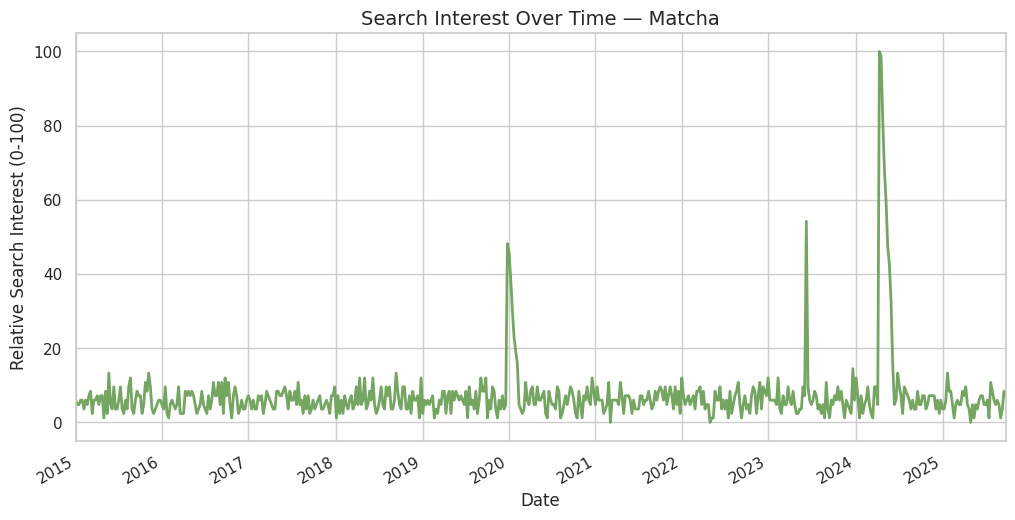

In [48]:
#Matcha Time Series Plot
fig, ax = plt.subplots(figsize=(12,6))
data['matcha'].plot(ax=ax, color='#74A662', linewidth=2)
ax.set_title("Search Interest Over Time — Matcha", fontsize=14)
ax.set_ylabel("Relative Search Interest (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_time_series_matcha.png")
plt.show()


Saved pytrends_eda_outputs/fig_time_series_dubai_chocolate.png


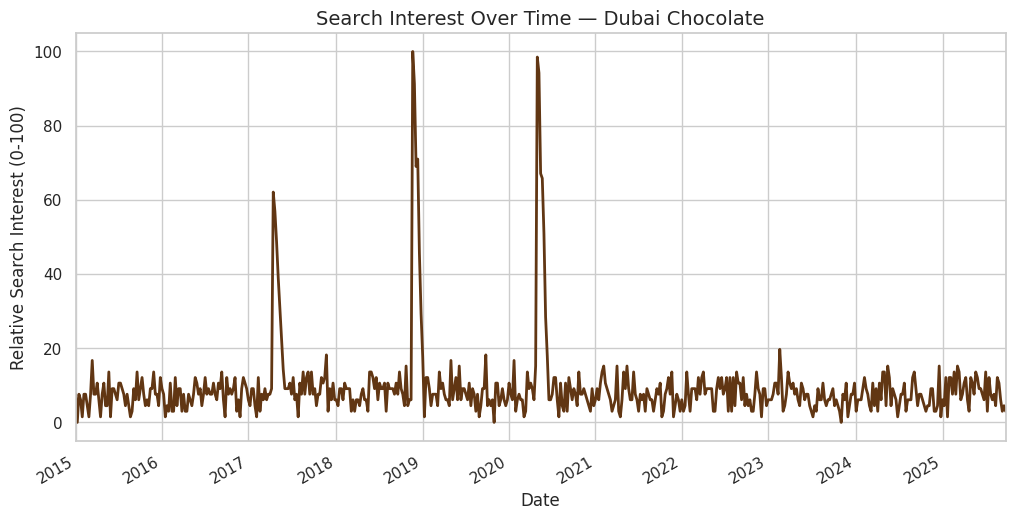

In [49]:
#Dubai Chocolate Time Series Plot
fig, ax = plt.subplots(figsize=(12,6))
data['dubai chocolate'].plot(ax=ax, color='#613613', linewidth=2)
ax.set_title("Search Interest Over Time — Dubai Chocolate", fontsize=14)
ax.set_ylabel("Relative Search Interest (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_time_series_dubai_chocolate.png")
plt.show()

Saved pytrends_eda_outputs/fig_time_series_baked_feta_cheese_pasta.png


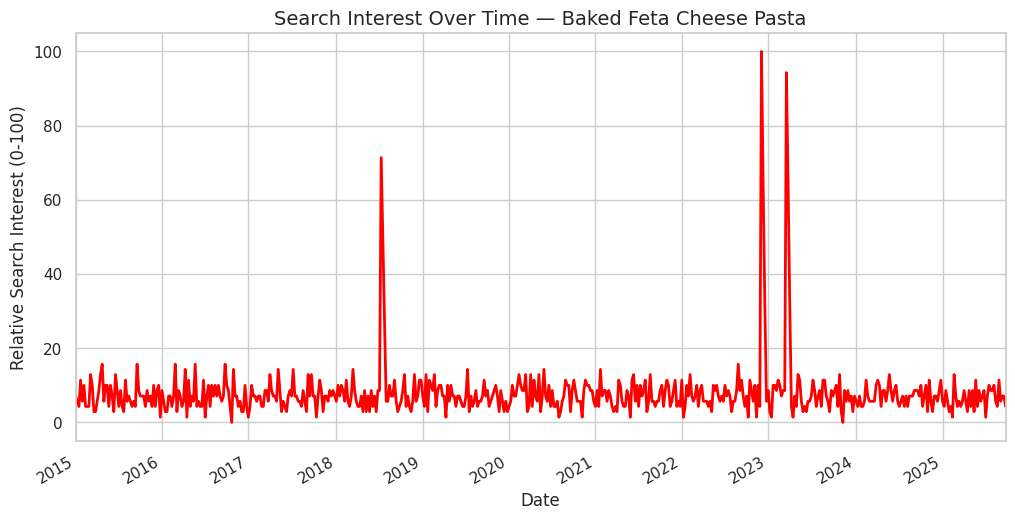

In [50]:
#Baked Feta Cheese Pasta Time Series Plot
fig, ax = plt.subplots(figsize=(12,6))
data['baked feta cheese pasta'].plot(ax=ax, color='red', linewidth=2)
ax.set_title("Search Interest Over Time — Baked Feta Cheese Pasta", fontsize=14)
ax.set_ylabel("Relative Search Interest (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_time_series_baked_feta_cheese_pasta.png")
plt.show()

## Rolling Mean (8-week)

Saved pytrends_eda_outputs/fig_rolling_8w_matcha.png


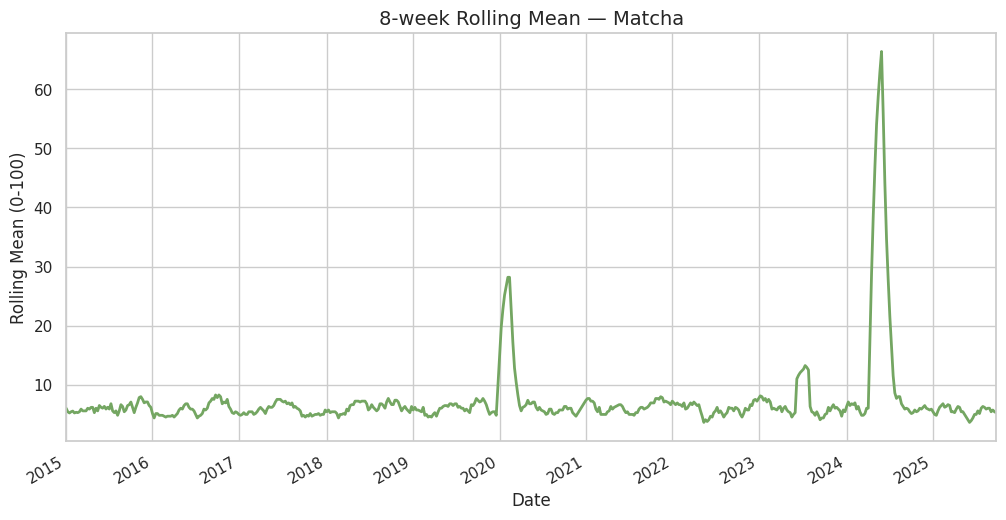

In [51]:
# Rolling Mean - Matcha
fig, ax = plt.subplots(figsize=(12,6))
data['matcha'].rolling(window=8, min_periods=1).mean().plot(ax=ax, color='#74A662', linewidth=2)
ax.set_title("8-week Rolling Mean — Matcha", fontsize=14)
ax.set_ylabel("Rolling Mean (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_rolling_8w_matcha.png")
plt.show()


Saved pytrends_eda_outputs/fig_rolling_8w_dubai_chocolate.png


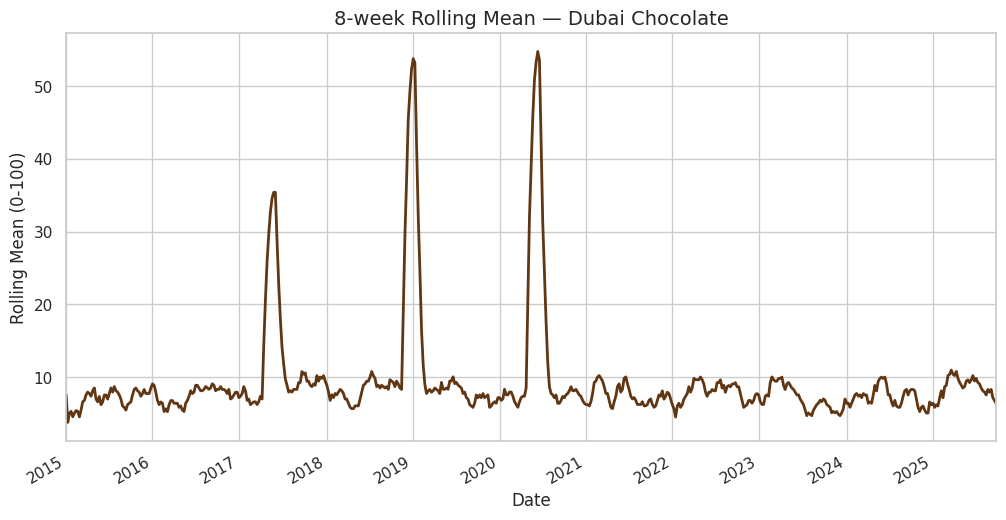

In [52]:
# Rolling Mean - Dubai Chocolate
fig, ax = plt.subplots(figsize=(12,6))
data['dubai chocolate'].rolling(window=8, min_periods=1).mean().plot(ax=ax, color='#613613', linewidth=2)
ax.set_title("8-week Rolling Mean — Dubai Chocolate", fontsize=14)
ax.set_ylabel("Rolling Mean (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_rolling_8w_dubai_chocolate.png")
plt.show()

Saved pytrends_eda_outputs/fig_rolling_8w_baked_feta_cheese_pasta.png


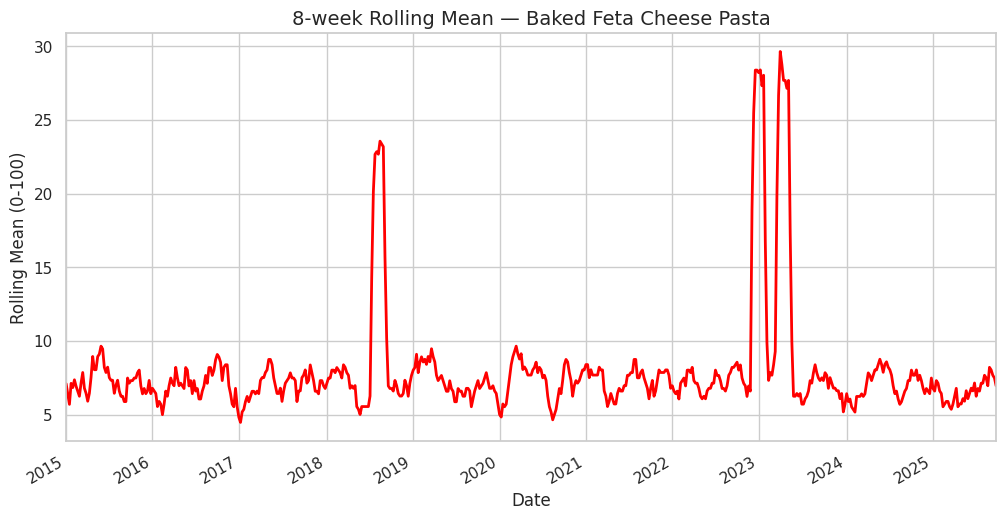

In [53]:
# Rolling Mean - Baked Feta Cheese Pasta
fig, ax = plt.subplots(figsize=(12,6))
data['baked feta cheese pasta'].rolling(window=8, min_periods=1).mean().plot(ax=ax, color='red', linewidth=2)
ax.set_title("8-week Rolling Mean — Baked Feta Cheese Pasta", fontsize=14)
ax.set_ylabel("Rolling Mean (0-100)")
ax.set_xlabel("Date")
fig.autofmt_xdate()
save_fig(fig, "fig_rolling_8w_baked_feta_cheese_pasta.png")
plt.show()

## Correlation Heatmap

Saved pytrends_eda_outputs/fig_correlation.png


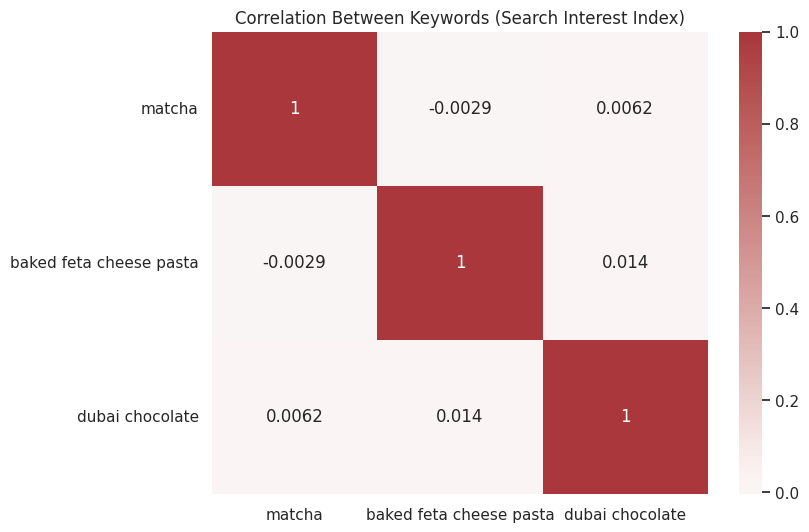

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='vlag', center=0, ax=ax)
ax.set_title('Correlation Between Keywords (Search Interest Index)')
save_fig(fig, 'fig_correlation.png')
plt.show()
